In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,350957,Male,50,1,41,0,1-2 Year,Yes,35915,124,240,0
1,239788,Female,48,1,28,0,1-2 Year,Yes,26873,124,274,0
2,348272,Female,34,1,41,0,1-2 Year,Yes,2630,156,138,1
3,73940,Female,43,1,28,0,1-2 Year,Yes,46877,124,223,0
4,292871,Male,29,1,28,1,< 1 Year,No,38009,152,106,0


In [4]:
train.shape

(304887, 12)

In [5]:
train.dtypes

id                       int64
Gender                  object
Age                      int64
Driving_License          int64
Region_Code              int64
Previously_Insured       int64
Vehicle_Age             object
Vehicle_Damage          object
Annual_Premium           int64
Policy_Sales_Channel     int64
Vintage                  int64
Response                 int64
dtype: object

In [84]:
numerical_features=train.select_dtypes(include=np.number)
categorical_features=train.select_dtypes(include=np.object)

In [85]:
train.Vehicle_Age.unique()

array(['1-2 Year', '< 1 Year', '> 2 Years'], dtype=object)

In [86]:
numerical_features.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,350957,50,1,41,0,35915,124,240,0
1,239788,48,1,28,0,26873,124,274,0
2,348272,34,1,41,0,2630,156,138,1
3,73940,43,1,28,0,46877,124,223,0
4,292871,29,1,28,1,38009,152,106,0


In [87]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,350957,Male,50,1,41,0,1-2 Year,Yes,35915,124,240,0
1,239788,Female,48,1,28,0,1-2 Year,Yes,26873,124,274,0
2,348272,Female,34,1,41,0,1-2 Year,Yes,2630,156,138,1
3,73940,Female,43,1,28,0,1-2 Year,Yes,46877,124,223,0
4,292871,Male,29,1,28,1,< 1 Year,No,38009,152,106,0


In [88]:
df=pd.concat([train,test])

In [89]:
from sklearn.preprocessing import LabelEncoder
x=['Vehicle_Damage','Vehicle_Age','Gender']
for i in x:
  le = LabelEncoder()
  df[i] = le.fit_transform(df[i])
  df[i]=df[i]+1

In [90]:
df = pd.get_dummies(df, columns=['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage'])

In [91]:
train = df[df['Response'].isnull()==False]
test = df[df['Response'].isnull()==True]
del test['Response']

In [26]:

train_df=train.copy()
test_df=test.copy()

In [27]:
from math import sqrt 
from sklearn.metrics import roc_auc_score

In [28]:
X = train_df.drop(labels=['Response'], axis=1)
y = train_df['Response'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=101)

In [29]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((274398, 26), (274398,), (30489, 26), (30489,))

In [30]:

categorical_features_indices = np.where(X_train.dtypes == 'category')[0]
categorical_features_indices

array([], dtype=int64)

In [31]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(#loss_function='CrossEntropy', 
                         eval_metric='AUC', 
                         #classes_count=2,
                         depth=3,
                         random_seed=121, 
                         iterations=1000, 
                         learning_rate=0.4,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)
cat.fit(X_train, y_train, verbose=100,
        use_best_model=True,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],
        plot=False)
predictions = cat.predict(X_cv)
print('accuracy:', roc_auc_score(y_cv, predictions))

0:	test: 0.8050422	test1: 0.8078142	best: 0.8078142 (0)	total: 206ms	remaining: 3m 26s
100:	test: 0.8591316	test1: 0.8616309	best: 0.8616828 (99)	total: 3.44s	remaining: 30.7s
200:	test: 0.8614208	test1: 0.8614510	best: 0.8618384 (150)	total: 6.54s	remaining: 26s
300:	test: 0.8631137	test1: 0.8612150	best: 0.8618384 (150)	total: 9.66s	remaining: 22.4s
400:	test: 0.8644031	test1: 0.8607985	best: 0.8618384 (150)	total: 12.9s	remaining: 19.2s
500:	test: 0.8655837	test1: 0.8606277	best: 0.8618384 (150)	total: 16.2s	remaining: 16.2s
600:	test: 0.8665716	test1: 0.8604626	best: 0.8618384 (150)	total: 20s	remaining: 13.3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.861838405
bestIteration = 150

Shrink model to first 151 iterations.
accuracy: 0.5046079902035208


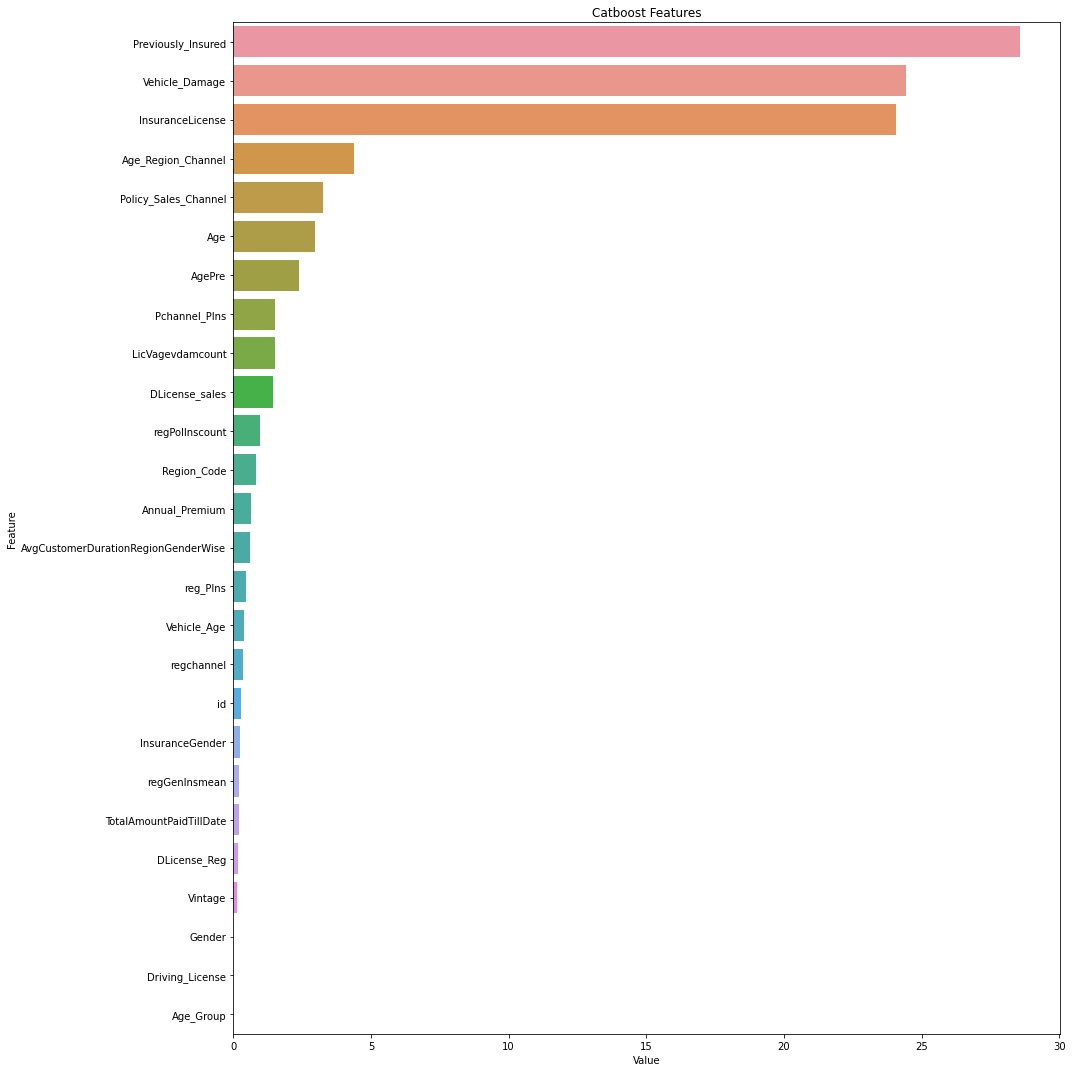

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()


In [23]:
Xtest = test_df

In [24]:
from sklearn.model_selection import KFold

errcat = []
y_pred_totcat = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='AUC', 
                         classes_count=3,
                         depth=6,
                         random_seed=121, 
                         iterations=100, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=0.8, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200, cat_features=categorical_features_indices)

    y_pred_cat = cat.predict(X_test)
    print("Accuracy: ", roc_auc_score(y_test,y_pred_cat, average='weighted'))

    errcat.append(roc_auc_score(y_test,y_pred_cat, average='weighted'))
    p = cat.predict(Xtest)
    y_pred_totcat.append(p)


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5016801787881405


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5010910548307769


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5003467493558428


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5009434758893476


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5010392002023946


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5011319286241535


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5011122706666211


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5011829942835535


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5017532708585327


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.500725416277406


In [27]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,350957,Male,50,1,41,0,1-2 Year,Yes,35915,124,240,0
1,239788,Female,48,1,28,0,1-2 Year,Yes,26873,124,274,0
2,348272,Female,34,1,41,0,1-2 Year,Yes,2630,156,138,1
3,73940,Female,43,1,28,0,1-2 Year,Yes,46877,124,223,0
4,292871,Male,29,1,28,1,< 1 Year,No,38009,152,106,0


In [6]:
train['regGenInsmean']=train.groupby(['Region_Code','Gender'])['Previously_Insured'].transform('count')

In [7]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,regGenInsmean
0,350957,Male,50,1,41,0,1-2 Year,Yes,35915,124,240,0,7808
1,239788,Female,48,1,28,0,1-2 Year,Yes,26873,124,274,0,37065
2,348272,Female,34,1,41,0,1-2 Year,Yes,2630,156,138,1,6813
3,73940,Female,43,1,28,0,1-2 Year,Yes,46877,124,223,0,37065
4,292871,Male,29,1,28,1,< 1 Year,No,38009,152,106,0,47982


In [8]:
train['Vintage'] = train['Vintage']/365

train['Vehicle_Age']=train['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})

train['Vehicle_Damage']=train['Vehicle_Damage'].replace({'Yes':1,'No':0})
train['Gender']=train['Gender'].replace({'Male':1,'Female':0})

#Analysis show that people in Age Group 30-60 have higher response rate so creating a separate feature
train['Age_Group'] = np.where((train['Age']<30) & (train['Age'] > 60),0,1)

In [9]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,regGenInsmean,Age_Group
0,350957,1,50,1,41,0,1,1,35915,124,0.657534,0,7808,1
1,239788,0,48,1,28,0,1,1,26873,124,0.750685,0,37065,1
2,348272,0,34,1,41,0,1,1,2630,156,0.378082,1,6813,1
3,73940,0,43,1,28,0,1,1,46877,124,0.610959,0,37065,1
4,292871,1,29,1,28,1,0,0,38009,152,0.290411,0,47982,1


In [10]:
train['regPolInscount']=train.groupby(['Region_Code','Policy_Sales_Channel'])['Previously_Insured'].transform('count')

In [11]:
train['LicVagevdamcount']=train.groupby(['Driving_License','Vehicle_Age','Vehicle_Damage'])['Previously_Insured'].transform('count')

In [12]:
train['AgePre']=train.groupby(['Age'])['Annual_Premium'].transform('mean')
train['regchannel']=train.groupby(['Region_Code'])['Policy_Sales_Channel'].transform('nunique')

In [13]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,regGenInsmean,Age_Group,regPolInscount,LicVagevdamcount,AgePre,regchannel
0,350957,1,50,1,41,0,1,1,35915,124,0.657534,0,7808,1,2389,102132,31749.131735,63
1,239788,0,48,1,28,0,1,1,26873,124,0.750685,0,37065,1,22019,102132,31360.471212,115
2,348272,0,34,1,41,0,1,1,2630,156,0.378082,1,6813,1,428,102132,26878.029584,63
3,73940,0,43,1,28,0,1,1,46877,124,0.610959,0,37065,1,22019,102132,30701.447952,115
4,292871,1,29,1,28,1,0,0,38009,152,0.290411,0,47982,1,10928,93264,27866.700423,115


In [14]:
train['TotalAmountPaidTillDate'] = train['Annual_Premium']*train['Vintage']

In [15]:
train['reg_PIns']=train.groupby(['Region_Code'])['Previously_Insured'].transform('count')

In [16]:
train['Pchannel_PIns']=train.groupby(['Policy_Sales_Channel'])['Previously_Insured'].transform('count')

In [17]:
train['Age_Region_Channel']=train.groupby(['Region_Code','Policy_Sales_Channel'])['Age'].transform('mean')

In [18]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,regGenInsmean,Age_Group,regPolInscount,LicVagevdamcount,AgePre,regchannel,TotalAmountPaidTillDate,reg_PIns,Pchannel_PIns,Age_Region_Channel
0,350957,1,50,1,41,0,1,1,35915,124,...,7808,1,2389,102132,31749.131735,63,23615.342466,14621,59170,45.868564
1,239788,0,48,1,28,0,1,1,26873,124,...,37065,1,22019,102132,31360.471212,115,20173.156164,85047,59170,46.967801
2,348272,0,34,1,41,0,1,1,2630,156,...,6813,1,428,102132,26878.029584,63,994.356164,14621,8525,38.257009
3,73940,0,43,1,28,0,1,1,46877,124,...,37065,1,22019,102132,30701.447952,115,28639.920548,85047,59170,46.967801
4,292871,1,29,1,28,1,0,0,38009,152,...,47982,1,10928,93264,27866.700423,115,11038.230137,85047,107762,27.052068


In [19]:
train['DLicense_Reg']=train.groupby(['Region_Code'])['Driving_License'].transform('count')

In [20]:
train['DLicense_sales']=train.groupby(['Policy_Sales_Channel'])['Driving_License'].transform('count')

In [21]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,regPolInscount,LicVagevdamcount,AgePre,regchannel,TotalAmountPaidTillDate,reg_PIns,Pchannel_PIns,Age_Region_Channel,DLicense_Reg,DLicense_sales
0,350957,1,50,1,41,0,1,1,35915,124,...,2389,102132,31749.131735,63,23615.342466,14621,59170,45.868564,14621,59170
1,239788,0,48,1,28,0,1,1,26873,124,...,22019,102132,31360.471212,115,20173.156164,85047,59170,46.967801,85047,59170
2,348272,0,34,1,41,0,1,1,2630,156,...,428,102132,26878.029584,63,994.356164,14621,8525,38.257009,14621,8525
3,73940,0,43,1,28,0,1,1,46877,124,...,22019,102132,30701.447952,115,28639.920548,85047,59170,46.967801,85047,59170
4,292871,1,29,1,28,1,0,0,38009,152,...,10928,93264,27866.700423,115,11038.230137,85047,107762,27.052068,85047,107762


In [22]:
train['AvgCustomerDurationRegionGenderWise'] = train.groupby(['Region_Code','Gender'])['Vintage'].transform('mean')

In [23]:
train['InsuranceLicense'] = train['Driving_License'].astype('str') + '' + train['Previously_Insured'].astype('str')
train['InsuranceGender'] = train['Gender'].astype('str') + '' + train['Previously_Insured'].astype('str')

In [24]:
train['Region_Code']=train['Region_Code'].astype(int)
train['Policy_Sales_Channel']=train['Policy_Sales_Channel'].astype(int)

In [25]:
cat_col=['Gender','Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel','InsuranceLicense','InsuranceGender']

In [125]:
X=train.drop(['id','Response'],axis=1)
y=train['Response'] 
X_main_test=test_df.drop(['id'],axis=1)

In [133]:
from lightgbm import LGBMClassifier
oof_pred               = np.zeros((len(train_df),))
y_pred_final           = np.zeros((len(test_df),))
num_models             = 3

n_splits               = 20
error                  = []

kf=StratifiedKFold(n_splits=10,shuffle=True,random_state=294)
    
for i,(train_idx,val_idx) in enumerate(kf.split(X,y)):    
    
    wghts                     = [0]*num_models
    test_roc_score            = []
    
    
    X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]

    X_val, y_val = X.iloc[val_idx, :], y.iloc[val_idx]
    

    print('\nFold: {}\n'.format(i+1))

    model1 = LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=-1,learning_rate=0.03,scale_pos_weight=7,objective='binary',metric='auc',
                 colsample_bytree=0.5,random_state=294,n_jobs=-1)
    model1.fit(X_train,y_train)
    testpred1 = model1.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred1))
    print("Test ROC AUC for model 1: %.4f"%(roc_auc_score(y_val, testpred1)))
    
    model2 = LGBMClassifier(boosting_type='gbdt',n_estimators=300,depth=-1,learning_rate=0.03,scale_pos_weight=7,objective='binary',metric='auc',
                 colsample_bytree=0.3,reg_alpha=2,random_state=294,n_jobs=-1)
    model2.fit(X_train,y_train)
    testpred2 = model2.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred2))
    print("Test ROC AUC for model 2: %.4f"%(roc_auc_score(y_val, testpred2)))
    
    model3 = LGBMClassifier(boosting_type='gbdt',n_estimators=400,depth=-1,learning_rate=0.03,scale_pos_weight=7,objective='binary',metric='auc',
                 colsample_bytree=0.4,reg_alpha=2,random_state=294,n_jobs=-1)
    model3.fit(X_train,y_train)
    testpred3 = model3.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred3))
    print("Test ROC AUC for model 3: %.4f"%(roc_auc_score(y_val, testpred3)))
    
    wghts              = np.exp(-1000*np.array(test_roc_score/sum(test_roc_score)))
    wghts              = wghts/sum(wghts)
    
    val_pred           = wghts[0]*testpred1+wghts[1]*testpred2 +wghts[2]*testpred3
    print('validation roc_auc_score fold-',i+1,': ',roc_auc_score(y_val, val_pred))
    
    oof_pred[val_idx]  = val_pred
    y_pred_final += (wghts[0]*model1.predict_proba(X_main_test)[:,1]+wghts[1]*model2.predict_proba(X_main_test)[:,1]+wghts[2]*model3.predict_proba(X_main_test)[:,1])/(n_splits)
    
    print('\n')
    
print('OOF ROC_AUC_Score:- ',(roc_auc_score(y,oof_pred)))


Fold: 1

[LightGBM] [Warning] Unknown parameter: depth
Test ROC AUC for model 1: 0.8578
[LightGBM] [Warning] Unknown parameter: depth
Test ROC AUC for model 2: 0.8580
[LightGBM] [Warning] Unknown parameter: depth
Test ROC AUC for model 3: 0.8580
validation roc_auc_score fold- 1 :  0.8580589407567718


ValueError: Number of features of the model must match the input. Model n_features_ is 25 and input n_features is 16 

In [130]:
X['InsuranceLicense']=X['InsuranceLicense'].astype('int64')
X['InsuranceGender']=X['InsuranceGender'].astype('int64')

In [132]:
X.shape

(304887, 25)